In [1]:
import sys
import random

sys.path.append("../../")
from simulation_classes.flying_cars import FlyingCars
from simulation_classes.simulation_periodic import SimulationPeriodic
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd


### 基本図を書くためのシミュレーションファイル

最終更新日: 2023/07/25

In [2]:
"""
シミュレーションの基本的な設定
基本的には ./periodic_simulation.ipynbを参考にしている。
DRONE_NUMについてfor文を回すためのファイル
"""

TOTAL_TIME = 300
time_step = 0.5
simulation_steps = int(TOTAL_TIME / time_step)
scale_factor = 20 
legal_speed = 1.5
real_legal_speed = min(2, legal_speed) * scale_factor * 3.6
TOTAL_DISTANCE = 50
boundary_condition = "PERIODIC"
UPDATE_RULE = "parallel"
MAX_ACC_REAL_WORLD = 2 # 0.2Gくらい
MIN_ACC_REAL_WORLD = 5 # 0.5Gくらい
FRONT_BRAKE_REAL_WORLD = 8 # 0.8Gくらい
should_scatter=True

# 先頭の車が前になるように置く(一番後ろの車はx=0でスタート)
def scatter_cars_around(total_distance, car_num, idx, scatter=False):
    if scatter:
        x_coordinates = [random.uniform(0, total_distance) for _ in range(car_num)]

        return sorted(x_coordinates, reverse=True)[idx]
        
    delta = total_distance / car_num
    x_coordinates = [total_distance - delta * (idx+1) for idx in range(car_num)]
    return x_coordinates[idx]

result_obj = {}

min_headway = 10 # 一番密度が高い時の車間距離を [m] で設定
drone_num_for_max_density = int(TOTAL_DISTANCE * scale_factor / min_headway) #その時のドローン台数
print(f"最大ドローン台数：{drone_num_for_max_density}台")
print(f"この設定だと法定速度は時速{real_legal_speed}km")
print(f"巡航距離は{TOTAL_DISTANCE * scale_factor /1000}kmです")
increment = 5

最大ドローン台数：100台
この設定だと法定速度は時速108.0km
巡航距離は1.0kmです


In [3]:
# シミュレーション用の関数

def simulate_with_parameters(**kwagrs):
    helly_params = kwagrs.get("helly_params")
    simulation_list = []

    for i in range(int(drone_num_for_max_density / increment)):
        DRONE_NUM = (i+1) * increment
        if (DRONE_NUM >206):
            break
        cars_list = [FlyingCars(xcor=scatter_cars_around(TOTAL_DISTANCE, DRONE_NUM, i, should_scatter),
                        ycor=0, 
                        v_0=0,
                        legal_speed=legal_speed, 
                        scale_factor=scale_factor,
                        drone_idx = i,
                        helly_params=helly_params,
                        )
                  for i in range(DRONE_NUM)]
        print(DRONE_NUM)
        simulation = SimulationPeriodic(
            TOTAL_TIME=TOTAL_TIME, 
            time_step=time_step, 
            scale_factor=scale_factor,
            drone_list=cars_list,
            TOTAL_DISTANCE=TOTAL_DISTANCE,
            UPDATE_RULE=UPDATE_RULE )
        simulation.run()
        simulation_list.append(simulation)
    
    return simulation_list


### ここからシミュレーション開始。

In [4]:
max_acc = MAX_ACC_REAL_WORLD / scale_factor # ルンゲクッタの時に加速度にdelta_tがかかることに注意
min_acc = MIN_ACC_REAL_WORLD / scale_factor
front_car_brake = FRONT_BRAKE_REAL_WORLD / scale_factor
rear_brake_acc = 0.4
front_brake_acc = 0.8


helly_params = {
    "max_accel": max_acc,
    "min_accel": min_acc,
    "front_car_brake":front_brake_acc,
    "lambda_1": 0.2,
    "lambda_2": 0.4,
    "d": 0.499,
    "T_des": 1,
    "isRss":False
  }
rss_params = {
    "max_accel": max_acc,
    "min_accel": min_acc,
    "front_car_brake": front_brake_acc,
    "rear_brake_acc":rear_brake_acc,
    "response_time":0.5, #秒で入れる,
    "lambda_1": 0.2,
    "lambda_2": 0.4,
    "d": 0.499,
    "T_des": 1,
    "isRss":True,
  }
simulation_list_helly = simulate_with_parameters(helly_params = helly_params)
simulation_list_rss = simulate_with_parameters(helly_params = rss_params)

5
===PARALLEL実行===
RSS距離= 0.499
my speed=0.000, delta_x=15.891, delta_v=0.000
RSS距離= 0.549
my speed=0.050, delta_x=15.891, delta_v=0.000
RSS距離= 0.599
my speed=0.100, delta_x=15.891, delta_v=0.000
RSS距離= 0.649
my speed=0.150, delta_x=15.891, delta_v=0.000
RSS距離= 0.6990000000000001
my speed=0.200, delta_x=15.891, delta_v=0.000
RSS距離= 0.749
my speed=0.250, delta_x=15.891, delta_v=0.000
RSS距離= 0.7989999999999999
my speed=0.300, delta_x=15.891, delta_v=0.000
RSS距離= 0.849
my speed=0.350, delta_x=15.891, delta_v=0.000
RSS距離= 0.899
my speed=0.400, delta_x=15.891, delta_v=0.000
RSS距離= 0.949
my speed=0.450, delta_x=15.891, delta_v=0.000
RSS距離= 0.9989999999999999
my speed=0.500, delta_x=15.891, delta_v=0.000
RSS距離= 1.049
my speed=0.550, delta_x=15.891, delta_v=0.000
RSS距離= 1.099
my speed=0.600, delta_x=15.891, delta_v=0.000
RSS距離= 1.149
my speed=0.650, delta_x=15.891, delta_v=0.000
RSS距離= 1.199
my speed=0.700, delta_x=15.891, delta_v=0.000
RSS距離= 1.249
my speed=0.750, delta_x=15.891, delta_v=0.00

ValueError: 追い抜きが発生しました

### ここからは解析に入る

In [47]:
def analysis(**kwagrs):
    dataList = []
    simulation_list = kwagrs.get("simulation_list",[])
    isRss = kwagrs.get("isRss",False)
    model = "RSS" if isRss else "Helly"
    for simulation in simulation_list:
        cars = simulation.drone_list
        # 流量を計算する
        velocity_list = []
        for car in cars:
            snap_frame = int(simulation_steps * 0.95)
            velocity_list.append(car.v_xList[snap_frame])
        mean_velocity = np.mean(np.array(velocity_list)) * scale_factor

        # 密度：1km当たりの台数
        rho = len(cars) / (TOTAL_DISTANCE * scale_factor)  * 1000
        flow = rho * mean_velocity

        # プロット用に保存
        dataToSave = {
            "density":rho,
            "flow":flow,
            "mean_velocity":mean_velocity,
            "start_position":"unscattered",
            "drone_num":len(cars),
            "model":model
        }
        dataList.append(dataToSave)

    df = pd.DataFrame(dataList)
    return df


In [54]:
simu = simulation_list_rss[19]
drone_list_19 = simu.drone_list
drone_list_19[-1].v_xList


[0,
 0.05,
 0.09242941838314551,
 0.12456367961428744,
 0.15063254526425182,
 0.17432413537616392,
 0.1985375995422067,
 0.22479518788417394,
 0.25376218070801626,
 0.2857230834606681,
 0.3206674925188255,
 0.35837426459100313,
 0.3984892279498118,
 0.4405924805996515,
 0.4842524035261196,
 0.529064982314228,
 0.5746786570743598,
 0.620806370214023,
 0.6672274754065742,
 0.7137825878184235,
 0.7603643396315589,
 0.8069065123431295,
 0.8533733419761987,
 0.8997501054963831,
 0.9460355109153563,
 0.9922359834465069,
 1.0383616707552172,
 1.0844238570007612,
 1.1304334406221914,
 1.17640015712249,
 1.2221694786806094,
 1.2606385679535512,
 1.2911141698257287,
 1.3150290878604336,
 1.3341075677913912,
 1.349761142500234,
 1.3629946235455297,
 1.3744779330286434,
 1.38464536685696,
 1.3937778830621383,
 1.4020608211843153,
 1.409621137840326,
 1.416550280978185,
 1.4229178298831826,
 1.4287794965329412,
 1.4341817970818092,
 1.4391647994017944,
 1.443763773239514,
 1.4480102172531628,
 1.45

In [48]:
df_helly = analysis(simulation_list=simulation_list_helly)
print(df_helly)

    density    flow  mean_velocity start_position  drone_num  model
0       5.0   150.0           30.0    unscattered          5  Helly
1      10.0   300.0           30.0    unscattered         10  Helly
2      15.0   450.0           30.0    unscattered         15  Helly
3      20.0   600.0           30.0    unscattered         20  Helly
4      25.0   750.0           30.0    unscattered         25  Helly
5      30.0   900.0           30.0    unscattered         30  Helly
6      35.0  1050.0           30.0    unscattered         35  Helly
7      40.0  1200.0           30.0    unscattered         40  Helly
8      45.0  1350.0           30.0    unscattered         45  Helly
9      50.0  1500.0           30.0    unscattered         50  Helly
10     55.0  1650.0           30.0    unscattered         55  Helly
11     60.0  1800.0           30.0    unscattered         60  Helly
12     65.0  1950.0           30.0    unscattered         65  Helly
13     70.0  2100.0           30.0    unscattere

### グラフのVisualization

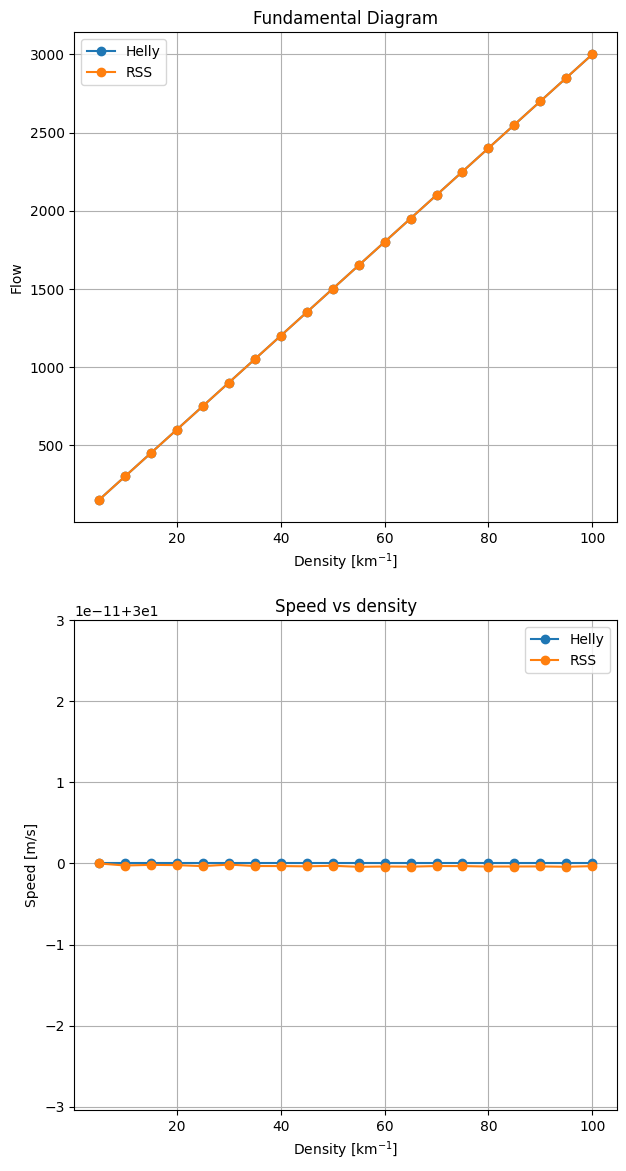

    density    flow  mean_velocity start_position  drone_num  model
0       5.0   150.0           30.0    unscattered          5  Helly
1      10.0   300.0           30.0    unscattered         10  Helly
2      15.0   450.0           30.0    unscattered         15  Helly
3      20.0   600.0           30.0    unscattered         20  Helly
4      25.0   750.0           30.0    unscattered         25  Helly
5      30.0   900.0           30.0    unscattered         30  Helly
6      35.0  1050.0           30.0    unscattered         35  Helly
7      40.0  1200.0           30.0    unscattered         40  Helly
8      45.0  1350.0           30.0    unscattered         45  Helly
9      50.0  1500.0           30.0    unscattered         50  Helly
10     55.0  1650.0           30.0    unscattered         55  Helly
11     60.0  1800.0           30.0    unscattered         60  Helly
12     65.0  1950.0           30.0    unscattered         65  Helly
13     70.0  2100.0           30.0    unscattere

In [36]:
df_helly = analysis(simulation_list=simulation_list_helly)
df_rss = analysis(simulation_list=simulation_list_rss, isRss=True)

# 折れ線グラフを描画
plt.figure(figsize=(7, 14))
plt.subplot(2, 1, 1)
plt.plot(df_helly["density"], df_helly["flow"], marker='o', label="Helly")
plt.plot(df_rss["density"], df_rss["flow"], marker='o', label="RSS")
plt.xlabel(r'Density [km$^{-1}$]')
plt.ylabel('Flow')
plt.title('Fundamental Diagram')
plt.grid(True)
plt.legend()


plt.subplot(2, 1, 2)
plt.plot(df_helly["density"], df_helly["mean_velocity"], marker='o', label="Helly")
plt.plot(df_rss["density"], df_rss["mean_velocity"], marker='o', label="RSS")
plt.xlabel(r'Density [km$^{-1}$]')
plt.ylabel('Speed [m/s]')
plt.title('Speed vs density')
plt.grid(True)
plt.legend()
plt.savefig(f"FD_RSS_vs_Helly_scatter={should_scatter}")
plt.show()

print(df_helly.head(20))
print(df_rss.head(20))

In [6]:
# デバッグ用
DRONE_NUM = 80
response_time = 0.5
max_acc = MAX_ACC_REAL_WORLD / scale_factor # ルンゲクッタの時に加速度にdelta_tがかかることに注意
min_acc = MIN_ACC_REAL_WORLD / scale_factor
front_brake_acc = 0.8
rear_brake_acc = 0.4

# 先頭の車が前になるように置く(一番後ろの車はx=0でスタート)
def scatter_cars_around(total_distance, car_num, scatter=False):
    if scatter:
        x_coordinates = [random.uniform(0, total_distance) for _ in range(car_num)]

        return sorted(x_coordinates, reverse=True)
        
    delta = total_distance / car_num
    x_coordinates = [total_distance - delta * (idx+1) for idx in range(car_num)]
    return x_coordinates

initial_xcors = scatter_cars_around(TOTAL_DISTANCE, DRONE_NUM, should_scatter)


In [7]:
min_acc = MIN_ACC_REAL_WORLD / scale_factor
rss_params = {
    "max_accel": max_acc,
    "min_accel": min_acc,
    "front_car_brake": front_brake_acc,
    "rear_brake_acc":rear_brake_acc,
    "response_time":response_time, #秒で入れる,
    "lambda_1": 0.2,
    "lambda_2": 0.4,
    "d": 0.499,
    "T_des": 1,
    "isRss":True,
  }

cars_list = [FlyingCars(xcor=initial_xcors[i],
                     ycor=0, 
                     v_0=0,
                     legal_speed=legal_speed, 
                     scale_factor=scale_factor,
                     drone_idx = i,
                     helly_params=rss_params,
                     )
               for i in range(DRONE_NUM)]
simulation = SimulationPeriodic(
            TOTAL_TIME=TOTAL_TIME, 
            time_step=time_step, 
            scale_factor=scale_factor,
            drone_list=cars_list,
            TOTAL_DISTANCE=TOTAL_DISTANCE,
            UPDATE_RULE=UPDATE_RULE )

result = simulation.run()
print((simulation.drone_list[1].v_xList))
print(result)
# simulation.create_video("test_nonRSS.mp4")

===PARALLEL実行===
FINISHED
[0, 0.0046293848138796384, 0.01165365805744425, 0.023328033828226617, 0.041522373694789054, 0.06760513944624866, 0.10234304468209479, 0.145833001809991, 0.19583300180999103, 0.24583300180999101, 0.295833001809991, 0.345833001809991, 0.395833001809991, 0.44583300180999097, 0.49583300180999096, 0.5362653379236821, 0.5593537716359056, 0.5676437468353536, 0.44264374683535357, 0.45714844292718965, 0.4651800099882084, 0.46747640563016457, 0.34247640563016457, 0.35018519857144914, 0.22518519857144914, 0.23552058003147916, 0.2385624896858626, 0.1135624896858626, 0, 0.00858082424979371, 0.017415846200671915, 0.02635044464564689, 0.03519719722161813, 0.04374231935289714, 0.051744295052320734, 0.05874581184921582, 0.062401821473188956, 0.06288798455836625, 0, 0.002215941898038778, 0.0045907932340187516, 0.007081442205696097, 0.009630798968488943, 0.012168487016458526, 0.014583042959198766, 0.01613765203647207, 0.016847015642738966, 0, 0.0010744204722820878, 0.00216146758

['0.000', '0.041', '0.079', '0.112', '0.141', '0.164', '0.183', '0.197', '0.208', '0.215', '0.219', '0.221', '0.221', '0.218', '0.212', '0.204', '0.194', '0.181', '0.166', '0.149', '0.131', '0.115', '0.100', '0.091', '0.089']
['0.000', '0.050', '0.100', '0.150', '0.200', '0.250', '0.300', '0.350', '0.400', '0.450', '0.500', '0.550', '0.600', '0.650', '0.700', '0.750', '0.775', '0.768', '0.736', '0.685', '0.620', '0.546', '0.466', '0.382']
['0.941', '0.931', '0.914', '0.891', '0.865', '0.836', '0.808', '0.782', '0.757', '0.734', '0.711', '0.689', '0.665', '0.638', '0.608', '0.575', '0.539', '0.504', '0.471', '0.446', '0.434', '0.440', '0.468', '0.523']
['3.622', '3.617', '3.607', '3.588', '3.558', '3.515', '3.457', '3.380', '3.284', '3.167', '3.027', '2.862', '2.673', '2.456', '2.212', '1.939', '1.649', '1.355', '1.070', '0.802', '0.558', '0.342', '0.159', '0.014']
['42.55', '42.57', '42.61', '42.66', '42.73', '42.81', '42.91', '43', '43.11', '43.22', '43.33', '43.44', '43.55', '43.66',

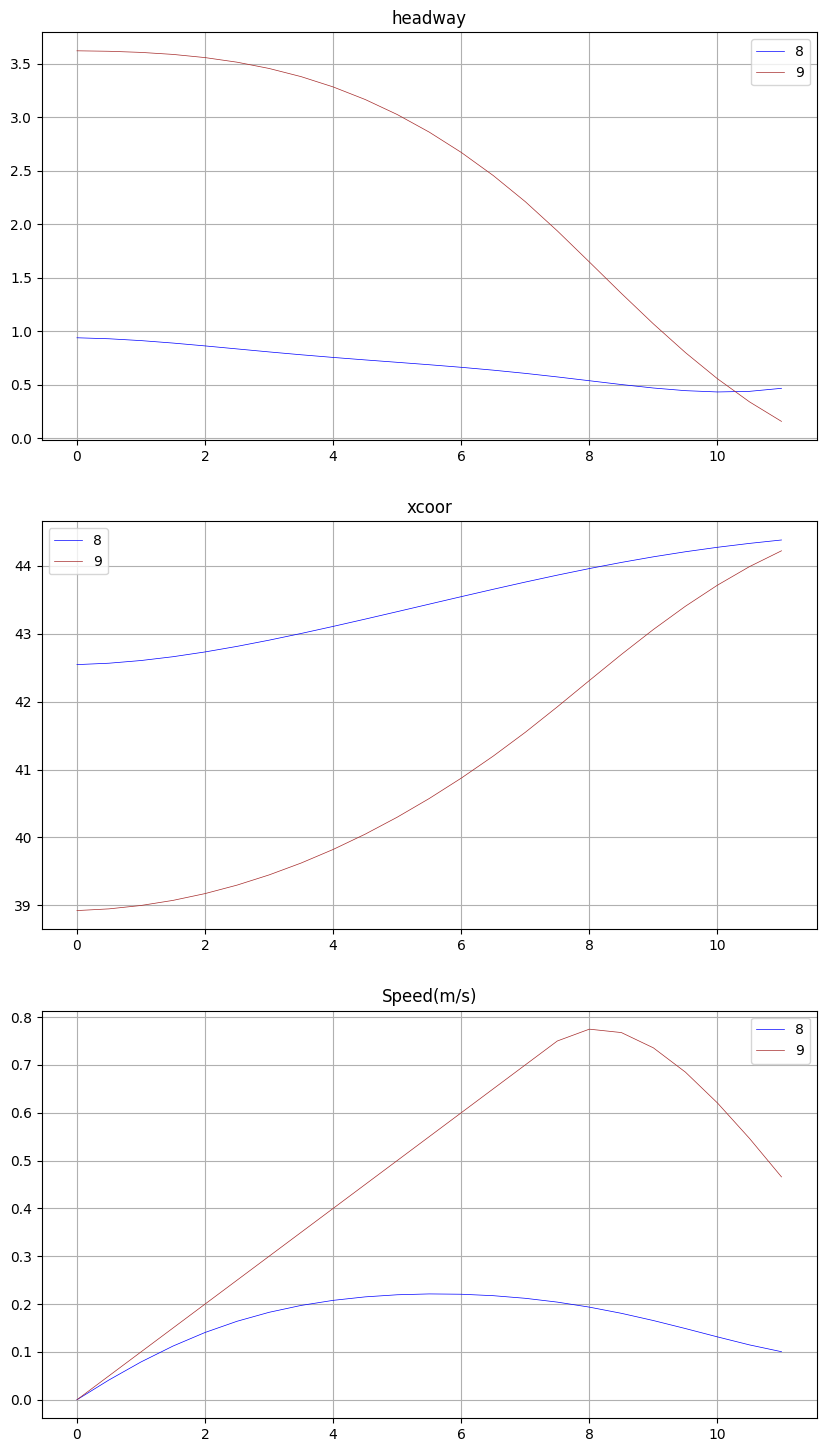

In [6]:
follower_idx = result["follower_idx"]
leader_idx = result["follower_idx"] -1
step = result["step"]
print(["{:.3f}".format(a) for a in simulation.drone_list[leader_idx].v_xList])
print(["{:.3f}".format(a) for a in simulation.drone_list[follower_idx].v_xList])
print("============")
print(["{:.3f}".format(a) for a in simulation.drone_list[leader_idx].headwayList])
print(["{:.3f}".format(a) for a in simulation.drone_list[follower_idx].headwayList])

print("============")
print(["{:.4g}".format(a) for a in simulation.drone_list[leader_idx].xcorList])
print(["{:.4g}".format(a) for a in simulation.drone_list[follower_idx].xcorList])
color_list = ["orange", "pink", "blue", "brown", "red", "green"]
drone_list = simulation.drone_list
print(min_acc)

plot_drone_list = [leader_idx,follower_idx]

t = np.arange(step) * time_step
plt.figure(figsize=(10, 18))
plt.subplot(3, 1, 1)
for idx in plot_drone_list:
    drone = drone_list[idx]
    plt.plot(t, np.array(drone.headwayList[:step]), color=color_list[idx % 6 ], linewidth=0.5, label=idx)
plt.legend()
plt.grid(True)
plt.title('headway')


plt.subplot(3, 1, 2)
t = np.arange(step) * time_step
for idx in plot_drone_list:
    drone = drone_list[idx]
    plt.plot(t, np.array(drone.xcorList[:step]), color=color_list[idx % 6], linewidth=0.5, label=idx)
plt.legend()
plt.grid(True)
plt.title('xcoor')


plt.subplot(3, 1, 3)
t = np.arange(step) * time_step
for idx in plot_drone_list:
    drone = drone_list[idx]
    plt.plot(t, np.array(drone.v_xList[:step]), color=color_list[idx % 6], linewidth=0.5, label=idx)
plt.legend()
plt.grid(True)
plt.title('Speed(m/s)')


plt.show()



In [12]:
def calc_rss_distance(my_speed, rss_params, delta_x, proceeding_speed = 0):
    rho_delay = rss_params.get("response_time", 0.5)
    min_comfortable_accel = rss_params.get("rear_brake_acc", min_acc*0.5)
    front_car_brake = rss_params.get("front_car_brake", min_acc)
    d = rss_params.get("d")
    lambda_1 = rss_params.get("lambda_1")
    front_car_brake_distance = proceeding_speed**2 / front_car_brake / 2
    brake_distance = (my_speed + max_acc*rho_delay)**2/(min_comfortable_accel)/2
    idle_distance = my_speed * rho_delay + max_acc * rho_delay**2 / 2
    rss_distance = d + brake_distance + idle_distance - front_car_brake_distance
    print("my speed:", my_speed)
    print( max_acc, min_comfortable_accel, front_car_brake)
    print(min_comfortable_accel)
    print("proceeding_speed:", proceeding_speed)
    print("front_car_brake_distance:", front_car_brake_distance)
    print("brake_distance:", brake_distance)
    print("idle_distance:", idle_distance)
    print("RSS距離: ",d + brake_distance + idle_distance - front_car_brake_distance)
    print("生じさせるべき加速度:", lambda_1 * (delta_x -rss_distance))


def calc_rss_info(rss_params, delta_x, proceeding_speed = 0):
    d = rss_params.get("d")
    k1 = (1 / rear_brake_acc - 1 / front_brake_acc) * 1/2
    k2 = response_time * (1 + max_acc / rear_brake_acc )
    k3 = max_acc*response_time**2 / 2 * (1+max_acc / rear_brake_acc) + d - delta_x
    v = ((k2 ** 2 - 4*k1*k3)**(1/2) - k2 ) / 2 /k1
    print(k1, k2, k3)
    print("定常速度=",v)

    print("======")
    print(k1 * v**2 + k2*v + k3)

    print("============")
    rho_delay = rss_params.get("response_time", 0.5)
    min_comfortable_accel = rss_params.get("rear_brake_acc", min_acc*0.5)
    front_car_brake = rss_params.get("front_car_brake", min_acc)
    front_car_brake_distance = proceeding_speed**2 / front_car_brake / 2
    brake_distance = (v + max_acc*rho_delay)**2/(min_comfortable_accel)/2
    idle_distance = v * rho_delay + max_acc * rho_delay**2 / 2

    print("my speed:", v)
    print("a_max:", max_acc)
    print(min_comfortable_accel)
    print("proceeding_speed:", proceeding_speed)
    print("front_car_brake_distance:", front_car_brake_distance)
    print("brake_distance:", brake_distance)
    print("idle_distance:", idle_distance)
    print("RSS距離: ",d + brake_distance + idle_distance - front_car_brake_distance)

print(rss_params)
calc_rss_distance(0.75, rss_params, 1.8, 0)
print()
# calc_rss_info(rss_params,1)

{'max_accel': 0.1, 'min_accel': 0.25, 'front_car_brake': 0.8, 'rear_brake_acc': 0.4, 'response_time': 0.5, 'lambda_1': 0.2, 'lambda_2': 0.4, 'd': 0.499, 'T_des': 1, 'isRss': True}
my speed: 0.75
0.1 0.4 0.8
0.4
proceeding_speed: 0
front_car_brake_distance: 0.0
brake_distance: 0.8000000000000002
idle_distance: 0.3875
RSS距離:  1.6865
生じさせるべき加速度: 0.022699999999999988

